# 快速入门

> 本 Notebook 基于 `LangChain v1.0`、`LangGraph v1.0` 撰写。

In [1]:
!pip show langchain

Name: langchain
Version: 1.0.2
Summary: Building applications with LLMs through composability
Home-page: https://docs.langchain.com/
Author: 
Author-email: 
License: MIT
Location: /Users/luochang/miniconda3/lib/python3.13/site-packages
Requires: langchain-core, langgraph, pydantic
Required-by: langmem


In [2]:
!pip show langgraph

Name: langgraph
Version: 1.0.2
Summary: Building stateful, multi-actor applications with LLMs
Home-page: 
Author: 
Author-email: 
License-Expression: MIT
Location: /Users/luochang/miniconda3/lib/python3.13/site-packages
Requires: langchain-core, langgraph-checkpoint, langgraph-prebuilt, langgraph-sdk, pydantic, xxhash
Required-by: langchain, langgraph-api, langgraph-runtime-inmem, langgraph-supervisor, langmem, trustcall


## 一、环境配置

**1）安装依赖**

在命令行中安装 Python 依赖：

```
pip install -r requirement.txt
```

**2）导入依赖**

In [3]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent

# 加载模型配置
# 请事先在 .env 中配置 DASHSCOPE_API_KEY
_ = load_dotenv()

## 二、简单的 Agent

In [4]:
# 配置大模型服务
llm = ChatOpenAI(
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    base_url=os.getenv("DASHSCOPE_BASE_URL"),
    model="qwen3-coder-plus",
)

# 创建一个简单的Agent
agent = create_agent(
    model=llm,
    system_prompt="You are a helpful assistant",
)

# 运行Agent
response = agent.invoke({'messages': '你好'})

response['messages'][-1].content

'你好！有什么我可以帮助你的吗？'

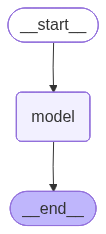

In [5]:
# 可视化 Agent
agent

## 三、带工具调用的 Agent

In [6]:
# 一个工具函数
def get_weather(city: str) -> str:
    """Get weather for a given city."""
    return f"It's always sunny in {city}!"

# 创建带工具调用的Agent
tool_agent = create_agent(
    model=llm,
    tools=[get_weather],
    system_prompt="You are a helpful assistant",
)

# 运行Agent
response = tool_agent.invoke(
    {"messages": [{"role": "user", "content": "what is the weather in sf"}]}
)

response['messages'][-1].content

"It's always sunny in sf!"

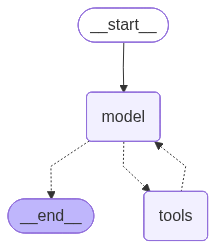

In [7]:
# 可视化 Agent
tool_agent

## 四、使用 `ToolRuntime` 控制工具权限

In [8]:
from typing import Literal, Any
from pydantic import BaseModel
from langchain.tools import tool, ToolRuntime

class Context(BaseModel):
    authority: Literal["admin", "user"]

# 创建带权限控制的tool，依赖ToolRuntime的内容进行判断
@tool
def math_add(runtime: ToolRuntime[Context, Any], a: int, b: int) -> int:
    """Add two numbers together."""
    authority = runtime.context.authority
    # 只有admin用户可以访问加法工具
    if authority != "admin":
        raise PermissionError("User does not have permission to add numbers")
    return a + b

# 创建带工具调用的Agent
tool_agent = create_agent(
    model=llm,
    tools=[get_weather, math_add],
    system_prompt="You are a helpful assistant",
)

# 在运行Agent时注入context
response = tool_agent.invoke(
    {"messages": [{"role": "user", "content": "请计算 8234783 + 94123832 = ?"}]},
    config={"configurable": {"thread_id": "1"}},
    context=Context(authority="admin"),
)

In [9]:
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

请计算 8234783 + 94123832 = ?
================================== Ai Message ==================================
Tool Calls:
  math_add (call_985e4f898e064650885c30c7)
 Call ID: call_985e4f898e064650885c30c7
  Args:
    a: 8234783
    b: 94123832
================================= Tool Message =================================
Name: math_add

102358615
================================== Ai Message ==================================

8234783 + 94123832 = 102358615。


In [10]:
# 验证计算结果是否正确
8234783 + 94123832

102358615

## 五、结构化输出

如果我们希望获得结构化输出（structured output），可以在 create_agent 函数中增加 `response_format` 参数。create_agent 会自动处理结构化输出。

首先约定输出格式。对于上面两数相加的例子，我们只需要输出一个字段 `output`，输出的数据结构如下：

In [11]:
from pydantic import BaseModel, Field

class CalcInfo(BaseModel):
    """Calculation information."""
    output: int = Field(description="The calculation result")

In [12]:
# 创建带结构化输出的Agent
structured_agent = create_agent(
    model=llm,
    tools=[get_weather, math_add],
    system_prompt="You are a helpful assistant",
    response_format=CalcInfo,
)

response = structured_agent.invoke(
    {"messages": [{"role": "user", "content": "请计算 8234783 + 94123832 = ?"}]},
    config={"configurable": {"thread_id": "1"}},
    context=Context(authority="admin"),
)

In [13]:
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

请计算 8234783 + 94123832 = ?
================================== Ai Message ==================================
Tool Calls:
  math_add (call_3a3539c1bb9d49ad9cf6c19d)
 Call ID: call_3a3539c1bb9d49ad9cf6c19d
  Args:
    a: 8234783
    b: 94123832
================================= Tool Message =================================
Name: math_add

102358615
================================== Ai Message ==================================
Tool Calls:
  CalcInfo (call_356d897869ae4617810c917d)
 Call ID: call_356d897869ae4617810c917d
  Args:
    output: 102358615
================================= Tool Message =================================
Name: CalcInfo

Returning structured response: output=102358615


In [14]:
response['messages'][-1]

ToolMessage(content='Returning structured response: output=102358615', name='CalcInfo', id='24650fde-c49c-4871-abb9-800ea487fba2', tool_call_id='call_356d897869ae4617810c917d')

## 六、流式输出

更多信息请查看 [streaming](https://docs.langchain.com/oss/python/langchain/streaming).

In [15]:
agent = create_agent(
    model=llm,
    tools=[get_weather],
)

for chunk in agent.stream(  
    {"messages": [{"role": "user", "content": "What is the weather in SF?"}]},
    stream_mode="updates",
):
    for step, data in chunk.items():
        print(f"step: {step}")
        print(f"content: {data['messages'][-1].content_blocks}")

step: model
content: [{'type': 'tool_call', 'name': 'get_weather', 'args': {'city': 'SF'}, 'id': 'call_0f612ce3a1684709b2127fa0'}]
step: tools
content: [{'type': 'text', 'text': "It's always sunny in SF!"}]
step: model
content: [{'type': 'text', 'text': "It's always sunny in SF!"}]


扩展阅读：
- [LangChain](https://docs.langchain.com/oss/python/langchain/overview)
- [LangGraph](https://docs.langchain.com/oss/python/langgraph/overview)
- [Deep Agents](https://docs.langchain.com/oss/python/deepagents/overview)
- [LangMem](https://langchain-ai.github.io/langmem/)
- [langgraph-101](https://github.com/langchain-ai/langgraph-101)